In [1]:
# These are all the modules we'll be using later. Make sure you can import them
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import json
from six.moves.urllib.request import urlretrieve

debug = False

In [2]:
url = 'http://orange.com/wgmn4901/data/'
data_dir = "../data/"

In [3]:
# list of current snapshots in data folder
!echo "Size\tName"
path = os.path.abspath(data_dir)
!ls -l $path | grep "tar.gz" | awk '{print $5 "\t" $9}'


"Size\tName"


'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [4]:
from shutil import copyfile
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    if os.path.exists(data_dir+filename):
      #copy from data folder to working directory
      copyfile(data_dir+filename, filename)
    else:
      filename, _ = urlretrieve(url + filename, filename) # may not work as expected
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

#clustersnapshot = maybe_download('clustersnapshot24022016.tar.gz', 249468)
clustersnapshot = maybe_download('ClusterSnapshot-20160803-11.tar.gz', 880567)

Found and verified ClusterSnapshot-20160803-11.tar.gz


In [5]:
def maybe_extract(filename,force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  print('Found the following application profile in %s:' % filename)
  for folder in data_folders:
    print ('  %s' % folder)
  return data_folders
  
clustersnapshot_folders = maybe_extract(clustersnapshot)

ClusterSnapshot-20160803-11 already present - Skipping extraction of ClusterSnapshot-20160803-11.tar.gz.
Found the following application profile in ClusterSnapshot-20160803-11.tar.gz:
  ClusterSnapshot-20160803-11\application_1464174962044_0284_json
  ClusterSnapshot-20160803-11\application_1464174962044_0285_json
  ClusterSnapshot-20160803-11\application_1464174962044_0286_json
  ClusterSnapshot-20160803-11\application_1464174962044_0287_json
  ClusterSnapshot-20160803-11\application_1464174962044_0288_json


In [8]:
import pandas as pd #this is how I usually import pandas

def load_application(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_task_list = []
  container_node_list = []
  container_node_mem_total_list = []
  container_node_CPU_total_list = []
  container_node_mem_rsrv_list = []
  container_node_CPU_rsrv_list = []
  container_mem_assigned_list = []
  container_CPU_assigned_list = []
  app_name_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_task = data["container_tasks"][0]["task_type"] #First task only
        app_name = data["application_info"]["appId"]
        if not data["nodeInfo"]:
            container_node = "null"
            container_node_mem_total = 0
            container_node_CPU_total = 0
            container_node_mem_rsrv = 0
            container_node_CPU_rsrv = 0
            container_mem_assigned = 0
            container_CPU_assigned = 0
        else:
            container_node = data["nodeInfo"]["id"]
            container_node_mem_total = data["nodeInfo"]["totalNodePhyMem"]
            container_node_CPU_total = data["nodeInfo"]["totalNodePhyCore"]
            container_node_mem_rsrv = data["nodeInfo"]["totalPmemAllocatedContainersMB"] * 1024
            container_node_CPU_rsrv = data["nodeInfo"]["totalVCoresAllocatedContainers"]
            container_mem_assigned = data["MemoryAssignedMB"] * 1024
            container_CPU_assigned = data["VCoresAssigned"]
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_task_list.insert(container_index,container_task)
        container_node_list.insert(container_index,container_node)
        container_node_mem_total_list.insert(container_index,container_node_mem_total)
        container_node_CPU_total_list.insert(container_index,container_node_CPU_total)
        container_node_mem_rsrv_list.insert(container_index,container_node_mem_rsrv)
        container_node_CPU_rsrv_list.insert(container_index,container_node_CPU_rsrv)
        container_mem_assigned_list.insert(container_index,container_mem_assigned)
        container_CPU_assigned_list.insert(container_index,container_CPU_assigned)
        app_name_list.insert(container_index,app_name)
      if not container_name:
        raise Exception('Unexpected container name')
      if container_starttime == 0:
        print('Unexpected container start time for %s' % container_name)
      if container_endtime == 0:
        print('Unexpected container end time for %s' % container_name)
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(container_starttime_list,container_endtime_list,
                     container_task_list,container_node_list,container_node_mem_total_list,
                     container_node_CPU_total_list,container_node_mem_rsrv_list,container_node_CPU_rsrv_list,
                     container_mem_assigned_list, container_CPU_assigned_list, app_name_list))
  columns=[ 'start', 'end', 'task', 'node','n_mem','n_CPU',
                                    'mem_rsrv','CPU_rsrv','mem','CPU','app']
  DataFrame = pd.DataFrame(data = DataSet, index=container_name_list,
                           columns=columns)
  return DataFrame, application_starttime, application_endtime

def load_snapshot(snapshot_folders):
  snapshot_starttime = 100000000000000 # really big number
  snapshot_endtime = 0
  snapshot_dataframe = pd.DataFrame()
  for application_folder in snapshot_folders: 
    dataframe, application_starttime, application_endtime = load_application(application_folder)
    if application_starttime < snapshot_starttime:
      snapshot_starttime = application_starttime
    if application_endtime > snapshot_endtime:
      snapshot_endtime = application_endtime
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
  return snapshot_dataframe, snapshot_starttime, snapshot_endtime

snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))

Unexpected container end time for container_e110_1464174962044_0284_01_000016
Unexpected container end time for container_e110_1464174962044_0284_01_000046
Unexpected container end time for container_e110_1464174962044_0285_01_000069
Unexpected container end time for container_e110_1464174962044_0286_01_000078
Unexpected container end time for container_e110_1464174962044_0287_01_000054
Unexpected container end time for container_e110_1464174962044_0287_01_000084
Unexpected container end time for container_e110_1464174962044_0287_01_000115
Unexpected container end time for container_e110_1464174962044_0287_01_000118
Unexpected container end time for container_e110_1464174962044_0288_01_000144
Snapshot start time: 1470220545188
Snapshot end time: 1470220997257
Snapshot duration: 452069 ms (or ~452 s or ~7 m)


In [15]:
snapshot_dataframe = snapshot_dataframe[ snapshot_dataframe.end != 0 ]

In [17]:
# Assign mem and CPU for lost_info container
MAP_mem = 2097152
MAP_core = 1
REDUCE_mem = MAP_mem
REDUCE_core = MAP_core
AM_mem = MAP_mem
AM_core = MAP_core
for index in snapshot_dataframe.index:
    if snapshot_dataframe.loc[index,'node'] == 'null':
        snapshot_dataframe['mem'][index] = MAP_mem
        snapshot_dataframe['CPU'][index] = MAP_core
        
#Place the null container to a random node
##Find node with least container at specific time
SnapshotDataFrame = snapshot_dataframe.sort_values(by="node")
node_list = SnapshotDataFrame.groupby('node').sum().index

def getnodewithleastcontainer(attimeT,SnapshotDFSorted):
    min_count = 100
    min_node = 'null'
    for node in node_list:
        if node == 'null':
            continue
        else:
            con_count = 0
            #filter
            TMP = SnapshotDFSorted[(SnapshotDFSorted.node == node)]
            for index in TMP.index:
                container_starttime = TMP.loc[index,'start']
                container_endtime = TMP.loc[index,'end']
                if container_starttime < attimeT and container_endtime > attimeT:
                    con_count += 1
            if con_count < min_count:
                min_count = con_count
                min_node = node
    print('%s - %d' %(min_node, min_count)) 
    return min_node, min_count

def getnoderesource(node, snapshot_dataframe):
    n_mem = 0
    n_cpu = 0
    allow_mem = 0
    allow_cpu = 0
    for index in snapshot_dataframe.index:
        if snapshot_dataframe.loc[index,'node'] == node:
            n_mem = snapshot_dataframe.loc[index,'n_mem']
            n_cpu = snapshot_dataframe.loc[index,'n_CPU']
            allow_mem = snapshot_dataframe.loc[index,'mem_rsrv']
            allow_cpu = snapshot_dataframe.loc[index,'CPU_rsrv']
            break
    return n_mem, n_cpu, allow_mem, allow_cpu

def fill_null_container(snapshot_dataframe):
    SnapshotDFSorted = snapshot_dataframe.sort(columns="start")
    for index in snapshot_dataframe.index:
        if snapshot_dataframe.loc[index,'node'] == 'null':
            container_starttime = snapshot_dataframe.loc[index,'start']
            node,_ = getnodewithleastcontainer(container_starttime,SnapshotDFSorted)
            n_mem, n_cpu, allow_mem, allow_cpu = getnoderesource(node, snapshot_dataframe)
            snapshot_dataframe['node'][index] = node
            snapshot_dataframe['n_mem'][index] = n_mem
            snapshot_dataframe['n_CPU'][index] = n_cpu
            snapshot_dataframe['mem_rsrv'][index] = allow_mem
            snapshot_dataframe['CPU_rsrv'][index] = allow_cpu
            # update info
            SnapshotDFSorted = snapshot_dataframe.sort(columns="start")
    return snapshot_dataframe

#snapshot_dataframe = fill_null_container(snapshot_dataframe)

In [21]:
# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import matplotlib.pyplot as plt
import matplotlib #only needed to determine Matplotlib version number
from random import randint
import pylab

# Enable inline plotting
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

random_application = clustersnapshot_folders[randint(0,len(clustersnapshot_folders)-1)]
print("App %s is selected for this example" % random_application.split('/')[1])

DataFrame, application_starttime, application_endtime = load_application(random_application)
DataFrameSorted = DataFrame.sort_values(by="start")

value = 1
for index in DataFrameSorted.index:
  starttime_rescaled = DataFrameSorted.loc[index,"start"]/1000 - snapshot_starttime/1000
  endtime_rescaled = DataFrameSorted.loc[index,"end"]/1000 - snapshot_starttime/1000
  task_duration = endtime_rescaled - starttime_rescaled
  x = np.linspace(starttime_rescaled,endtime_rescaled,task_duration)
  container_data = np.linspace(value,value,task_duration)
  if DataFrameSorted.loc[index,"task"] == "MAP":
    plt.plot(x,container_data,"ro")
  elif DataFrameSorted.loc[index,"task"] == "REDUCE":
    plt.plot(x,container_data,"bo")
  elif DataFrameSorted.loc[index,"task"] == "AM":
    plt.plot(x,container_data,"yo")
  else:
    print("not applicable for %s" % index)
  value = value + 1


IndexError: list index out of range

In [22]:
SnapshotDataFrame = snapshot_dataframe.sort_values(by="node")
print('List of containers with no information on node ID:')
SnapshotDataFrame.groupby('node').count().task

List of containers with no information on node ID:


node
svr04.spo:45454     7
svr05.spo:45454    24
svr06.spo:45454    36
svr07.spo:45454    32
svr08.spo:45454    25
svr09.spo:45454    42
svr10.spo:45454    65
svr11.spo:45454    47
svr12.spo:45454    32
svr13.spo:45454    33
svr14.spo:45454    26
svr15.spo:45454    35
Name: task, dtype: int64

not applicable for container_e110_1464174962044_0287_01_000133
not applicable for container_e110_1464174962044_0288_01_000146
not applicable for container_e110_1464174962044_0288_01_000147
not applicable for container_e110_1464174962044_0288_01_000148


(0.0, 500.0, 0.0, 100.0)

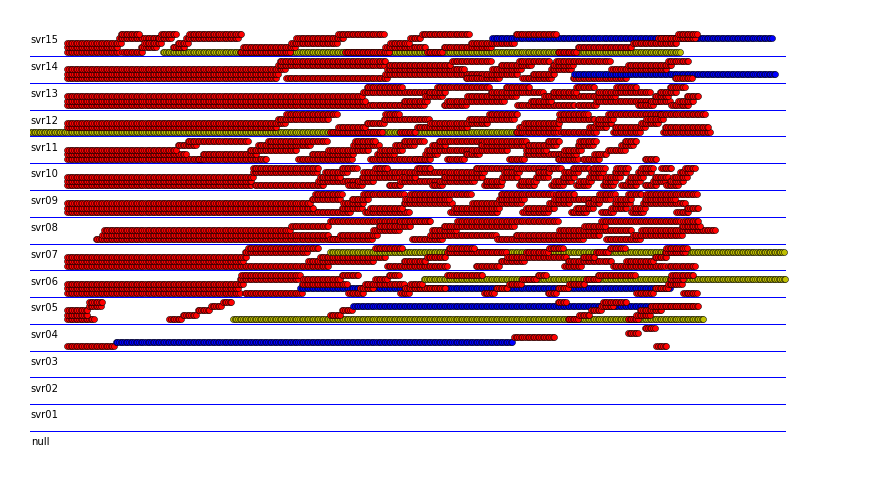

In [23]:
##### pylab.rcParams['figure.figsize'] = (15.0, 8.0)

#snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
snapshot_duration = snapshot_endtime - snapshot_starttime
SnapshotDFSorted = snapshot_dataframe.sort_values(by="start")
#print(DataFrameSorted)

# Initialize slot for drawing
slot = {}
for node in snapshot_dataframe.groupby('node').count().task.index:
  slot[node] = 1

slot_max = 6

for index in SnapshotDFSorted.index:
  if slot[SnapshotDFSorted.loc[index,"node"]] >= slot_max:
    slot[SnapshotDFSorted.loc[index,"node"]] = 1 #reset slot
  starttime_rescaled = SnapshotDFSorted.loc[index,"start"]/1000 - snapshot_starttime/1000
  endtime_rescaled = SnapshotDFSorted.loc[index,"end"]/1000 - snapshot_starttime/1000
  task_duration = endtime_rescaled - starttime_rescaled
  if SnapshotDFSorted.loc[index,"node"] == "null":
    current_slot = slot[SnapshotDFSorted.loc[index,"node"]]
  else:
    current_slot = (int(SnapshotDFSorted.loc[index,"node"][3:5]) * slot_max) + slot[SnapshotDFSorted.loc[index,"node"]]
    #print(str(int(SnapshotDFSorted.loc[index,"node"][3:5])))
  x = np.linspace(starttime_rescaled,endtime_rescaled-1,task_duration)
  container_data = np.linspace(current_slot,current_slot,task_duration)
  if SnapshotDFSorted.loc[index,"task"] == "MAP":
    plt.plot(x,container_data,"ro")
  elif SnapshotDFSorted.loc[index,"task"] == "REDUCE":
    plt.plot(x,container_data,"bo")
  elif SnapshotDFSorted.loc[index,"task"] == "AM":
    plt.plot(x,container_data,"yo")
  else:
    print("not applicable for %s" % index)
  slot[SnapshotDFSorted.loc[index,"node"]] = slot[SnapshotDFSorted.loc[index,"node"]] + 1

# draw line separate node:
x = np.linspace(0,snapshot_duration/1000-1,snapshot_duration/1000)
for line in np.linspace(1,len(slot)+3,len(slot)+3): # 4 locations for null
  y_value = line * slot_max
  y = np.linspace(y_value,y_value,snapshot_duration/1000)
  plt.plot(x,y,'-b')

plt.text(0.2,slot_max*1-3,"null")
plt.text(0.2,slot_max*2-3,"svr01")
plt.text(0.2,slot_max*3-3,"svr02")
plt.text(0.2,slot_max*4-3,"svr03")
plt.text(0.2,slot_max*5-3,"svr04")
plt.text(0.2,slot_max*6-3,"svr05")
plt.text(0.2,slot_max*7-3,"svr06")
plt.text(0.2,slot_max*8-3,"svr07")
plt.text(0.2,slot_max*9-3,"svr08")
plt.text(0.2,slot_max*10-3,"svr09")
plt.text(0.2,slot_max*11-3,"svr10")
plt.text(0.2,slot_max*12-3,"svr11")
plt.text(0.2,slot_max*13-3,"svr12")
plt.text(0.2,slot_max*14-3,"svr13")
plt.text(0.2,slot_max*15-3,"svr14")
plt.text(0.2,slot_max*16-3,"svr15")
plt.axis('off')

In [24]:
def load_application_cpu_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_load_list = []
  cpu_us_list = []
  cpu_sys_list = []
  cpu_id_list = []
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["cpu_usage"]:
          print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["cpu_usage"]:
            container_capture_time = record["capture_time"]
            container_load = record["container_load"] / 100
            cpu_us = record["cpu_us"]
            cpu_sys = record["cpu_sy"]
            cpu_id = record["cpu_id"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_load_list.insert(record_index,container_load)
            cpu_us_list.insert(record_index,cpu_us)
            cpu_sys_list.insert(record_index,cpu_sys)
            cpu_id_list.insert(record_index,cpu_id)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_load_list,cpu_us_list,cpu_sys_list,cpu_id_list))
  columns=[ 'timestamp','name','cpu_load', 'cpu_us', 'cpu_sys', 'cpu_id']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_cpu_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_cpu_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe

snapshot_cpu_profile = load_snapshot_cpu_profile(clustersnapshot_folders)
snapshot_cpu_profile

No infomation for container container_e110_1464174962044_0284_01_000016, ignore it
No infomation for container container_e110_1464174962044_0284_01_000046, ignore it
No infomation for container container_e110_1464174962044_0284_01_000073, ignore it
No infomation for container container_e110_1464174962044_0285_01_000069, ignore it
No infomation for container container_e110_1464174962044_0286_01_000078, ignore it
No infomation for container container_e110_1464174962044_0287_01_000054, ignore it
No infomation for container container_e110_1464174962044_0287_01_000084, ignore it
No infomation for container container_e110_1464174962044_0287_01_000115, ignore it
No infomation for container container_e110_1464174962044_0287_01_000118, ignore it
No infomation for container container_e110_1464174962044_0287_01_000131, ignore it
No infomation for container container_e110_1464174962044_0287_01_000133, ignore it
No infomation for container container_e110_1464174962044_0288_01_000144, ignore it
No i

timestamp                                         name  cpu_load  \
0     1470220546  container_e110_1464174962044_0284_01_000001     1.336   
1     1470220547  container_e110_1464174962044_0284_01_000001     1.089   
2     1470220548  container_e110_1464174962044_0284_01_000001     1.219   
3     1470220549  container_e110_1464174962044_0284_01_000001     1.608   
4     1470220550  container_e110_1464174962044_0284_01_000001     2.116   
5     1470220551  container_e110_1464174962044_0284_01_000001     2.146   
6     1470220552  container_e110_1464174962044_0284_01_000001     1.887   
7     1470220553  container_e110_1464174962044_0284_01_000001     1.618   
8     1470220554  container_e110_1464174962044_0284_01_000001     1.778   
9     1470220555  container_e110_1464174962044_0284_01_000001     1.078   
10    1470220556  container_e110_1464174962044_0284_01_000001     1.109   
11    1470220557  container_e110_1464174962044_0284_01_000001     1.138   
12    1470220558  container_e110_1464174962044_0284_01_000001     1.249   
13    1470220559  container_e110_1464174962044_0284_01_000001     1.209   
14    1470220560  container_e110_1464174962044_0284_01_000001     2.098   
15    1470220561  container_e110_1464174962044_0284_01_000001     1.418   
16    1470220562  container_e110_1464174962044_0284_01_000001     1.417   
17    1470220563  container_e110_1464174962044_0284_01_000001     1.587   
18    1470220564  container_e110_1464174962044_0284_01_000001     1.847   
19    1470220565  container_e110_1464174962044_0284_01_000001     1.278   
20    1470220566  container_e110_1464174962044_0284_01_000001     1.597   
21    1470220567  container_e110_1464174962044_0284_01_000001     0.499   
22    1470220568  container_e110_1464174962044_0284_01_000001     1.812   
23    1470220569  container_e110_1464174962044_0284_01_000001     0.090   
24    1470220570  container_e110_1464174962044_0284_01_000001     0.050   
25    1470220571  container_e110_1464174962044_0284_01_000001     0.869   
26    1470220572  container_e110_1464174962044_0284_01_000001     0.450   
27    1470220573  container_e110_1464174962044_0284_01_000001     0.030   
28    1470220574  container_e110_1464174962044_0284_01_000001     0.119   
29    1470220575  container_e110_1464174962044_0284_01_000001     0.040   
...          ...                                          ...       ...   
1560  1470220937  container_e110_1464174962044_0288_01_000140     1.389   
1561  1470220938  container_e110_1464174962044_0288_01_000140     1.718   
1562  1470220939  container_e110_1464174962044_0288_01_000140     1.689   
1563  1470220940  container_e110_1464174962044_0288_01_000140     0.889   
1564  1470220941  container_e110_1464174962044_0288_01_000140     1.267   
1565  1470220942  container_e110_1464174962044_0288_01_000140     1.439   
1566  1470220938  container_e110_1464174962044_0288_01_000141     0.892   
1567  1470220939  container_e110_1464174962044_0288_01_000141     1.389   
1568  1470220940  container_e110_1464174962044_0288_01_000141     1.109   
1569  1470220941  container_e110_1464174962044_0288_01_000141     1.179   
1570  1470220942  container_e110_1464174962044_0288_01_000141     0.939   
1571  1470220943  container_e110_1464174962044_0288_01_000141     1.049   
1572  1470220944  container_e110_1464174962044_0288_01_000141     1.235   
1573  1470220937  container_e110_1464174962044_0288_01_000142     1.318   
1574  1470220938  container_e110_1464174962044_0288_01_000142     1.698   
1575  1470220939  container_e110_1464174962044_0288_01_000142     2.038   
1576  1470220940  container_e110_1464174962044_0288_01_000142     1.159   
1577  1470220941  container_e110_1464174962044_0288_01_000142     1.369   
1578  1470220942  container_e110_1464174962044_0288_01_000142     1.697   
1579  1470220938  container_e110_1464174962044_0288_01_000143     1.039   
1580  1470220939  container_e110_1464174962044_0288_01_000143     1.818   
1581  1470220940  container_e110

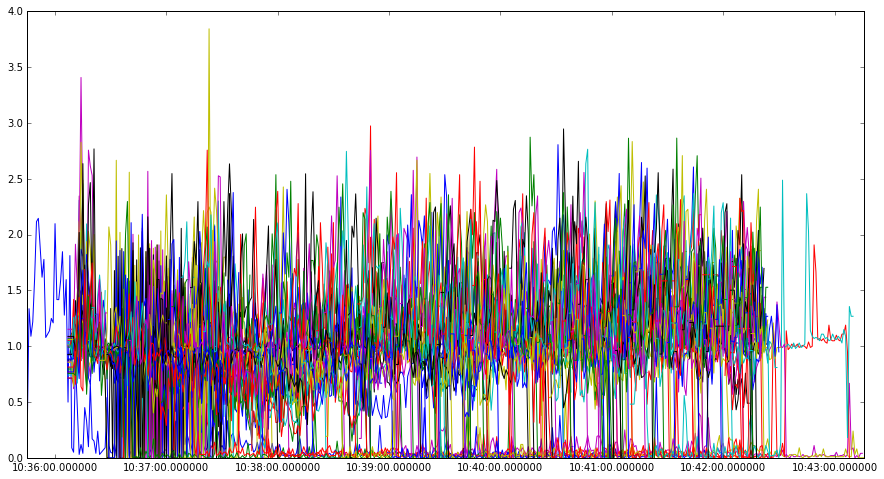

In [25]:
def get_cpu_actual_use(container_name, snapshot_dataframe, snapshot_cpu_profile):
  container_starttime = snapshot_dataframe.loc[container_name,'start']
  container_endtime = snapshot_dataframe.loc[container_name,'end']
  rescaled_container_starttime = container_starttime / 1000
  rescaled_container_endtime = container_endtime / 1000
  duration = rescaled_container_endtime - rescaled_container_starttime
  container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
  data = np.linspace(0,0,duration)
  container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

  cpu_container_filtered = snapshot_cpu_profile[(snapshot_cpu_profile.name == container_name)]
  index = cpu_container_filtered.timestamp.tolist()
  cpu_load = cpu_container_filtered.cpu_load.tolist()
  container_data1 = pd.Series(cpu_load,index=pd.to_datetime(index,unit='s'))
  container_data3 = container_data1 + container_data2
  container_data4 = container_data3.interpolate(method='time')
  for index in container_data4.index:
    if pd.isnull(container_data4[index]):
      container_data4[index] = container_data4.mean()
  if len(container_data4) > len(container_data2):
    a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
    if debug == True:
        print(a)
    #print(container_data4)
    #print(container_data3)
    #print(container_data2.index)
    #raise Exception('Return length mismatch')
    
  return container_data4

# Filter to remove containers with no informaction of the node, or to select specific nodes
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
for i in SnapshotDFFiltered.index:
  a = get_cpu_actual_use(i,snapshot_dataframe, snapshot_cpu_profile)
  plt.plot(a)

In [27]:
def load_application_mem_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_mem_virt_list = []
  container_mem_res_list = []
  container_mem_shr_list = []
  used_pmem_list = [] #system info
  swap_cached_list = [] # system info
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["memory_usage"]:
          print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["memory_usage"]:
            container_capture_time = record["capture_time"]
            container_mem_virt = record["virt"]
            container_mem_res = record["res"]
            container_mem_shr = record["shr"]
            used_pmem = record["used_pmem"]
            swap_cached = record["swap_cached"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_mem_virt_list.insert(record_index,container_mem_virt)
            container_mem_res_list.insert(record_index,container_mem_res)
            container_mem_shr_list.insert(record_index,container_mem_shr)
            used_pmem_list.insert(record_index,used_pmem)
            swap_cached_list.insert(record_index,swap_cached)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_mem_virt_list,
                     container_mem_res_list,container_mem_shr_list,used_pmem_list,swap_cached_list))
  columns=[ 'timestamp','name','virt', 'res', 'shr', 'used_pmem','swap_cached']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_mem_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_mem_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe

snapshot_mem_profile = load_snapshot_mem_profile(clustersnapshot_folders)
snapshot_mem_profile

No infomation for container container_e110_1464174962044_0284_01_000016, ignore it
No infomation for container container_e110_1464174962044_0284_01_000046, ignore it
No infomation for container container_e110_1464174962044_0284_01_000073, ignore it
No infomation for container container_e110_1464174962044_0285_01_000069, ignore it
No infomation for container container_e110_1464174962044_0286_01_000078, ignore it
No infomation for container container_e110_1464174962044_0287_01_000054, ignore it
No infomation for container container_e110_1464174962044_0287_01_000084, ignore it
No infomation for container container_e110_1464174962044_0287_01_000115, ignore it
No infomation for container container_e110_1464174962044_0287_01_000118, ignore it
No infomation for container container_e110_1464174962044_0287_01_000131, ignore it
No infomation for container container_e110_1464174962044_0287_01_000133, ignore it
No infomation for container container_e110_1464174962044_0288_01_000144, ignore it
No i

timestamp                                         name        virt  \
0     1470220546  container_e110_1464174962044_0284_01_000001  1407188992   
1     1470220547  container_e110_1464174962044_0284_01_000001  1420820480   
2     1470220548  container_e110_1464174962044_0284_01_000001  1420820480   
3     1470220549  container_e110_1464174962044_0284_01_000001  1428160512   
4     1470220550  container_e110_1464174962044_0284_01_000001  1435500544   
5     1470220551  container_e110_1464174962044_0284_01_000001  1440743424   
6     1470220552  container_e110_1464174962044_0284_01_000001  1440743424   
7     1470220553  container_e110_1464174962044_0284_01_000001  1440743424   
8     1470220554  container_e110_1464174962044_0284_01_000001  1441792000   
9     1470220555  container_e110_1464174962044_0284_01_000001  1441792000   
10    1470220556  container_e110_1464174962044_0284_01_000001  1443889152   
11    1470220557  container_e110_1464174962044_0284_01_000001  1449132032   
12    1470220558  container_e110_1464174962044_0284_01_000001  1451229184   
13    1470220559  container_e110_1464174962044_0284_01_000001  1451229184   
14    1470220560  container_e110_1464174962044_0284_01_000001  1453326336   
15    1470220561  container_e110_1464174962044_0284_01_000001  1454374912   
16    1470220562  container_e110_1464174962044_0284_01_000001  1454374912   
17    1470220563  container_e110_1464174962044_0284_01_000001  1454374912   
18    1470220564  container_e110_1464174962044_0284_01_000001  1493172224   
19    1470220565  container_e110_1464174962044_0284_01_000001  1503657984   
20    1470220566  container_e110_1464174962044_0284_01_000001  1503657984   
21    1470220567  container_e110_1464174962044_0284_01_000001  1503657984   
22    1470220568  container_e110_1464174962044_0284_01_000001  1566572544   
23    1470220569  container_e110_1464174962044_0284_01_000001  1566572544   
24    1470220570  container_e110_1464174962044_0284_01_000001  1566572544   
25    1470220571  container_e110_1464174962044_0284_01_000001  1566572544   
26    1470220572  container_e110_1464174962044_0284_01_000001  1566572544   
27    1470220573  container_e110_1464174962044_0284_01_000001  1566572544   
28    1470220574  container_e110_1464174962044_0284_01_000001  1566572544   
29    1470220575  container_e110_1464174962044_0284_01_000001  1566572544   
...          ...                                          ...         ...   
1560  1470220937  container_e110_1464174962044_0288_01_000140  1866465280   
1561  1470220938  container_e110_1464174962044_0288_01_000140  1876951040   
1562  1470220939  container_e110_1464174962044_0288_01_000140  1881145344   
1563  1470220940  container_e110_1464174962044_0288_01_000140  1882193920   
1564  1470220941  container_e110_1464174962044_0288_01_000140  1883242496   
1565  1470220942  container_e110_1464174962044_0288_01_000140           0   
1566  1470220938  container_e110_1464174962044_0288_01_000141  1864368128   
1567  1470220939  container_e110_1464174962044_0288_01_000141  1885339648   
1568  1470220940  container_e110_1464174962044_0288_01_000141  1895825408   
1569  1470220941  container_e110_1464174962044_0288_01_000141  1905262592   
1570  1470220942  container_e110_1464174962044_0288_01_000141  1905262592   
1571  1470220943  container_e110_1464174962044_0288_01_000141  1906311168   
1572  1470220944  container_e110_1464174962044_0288_01_000141  1906311168   
1573  1470220937  container_e110_1464174962044_0288_01_000142  1862270976   
1574  1470220938  container_e110_1464174962044_0288_01_000142  1870659584   
1575  1470220939  container_e110_1464174962044_0288_01_000142  1877999616   
1576  1470220940  container_e110_1464174962044_0288_01_000142  1883242496   
1577  1470220941  container_e110_1464174962044_0288_01_000142  1884291072   
1578  1470220942  container_e110_1464174962044_0288_01_000142  1884291072   
1579  1470220938  container_e110_1464174962044_0288_01_000143  1864368128   
158

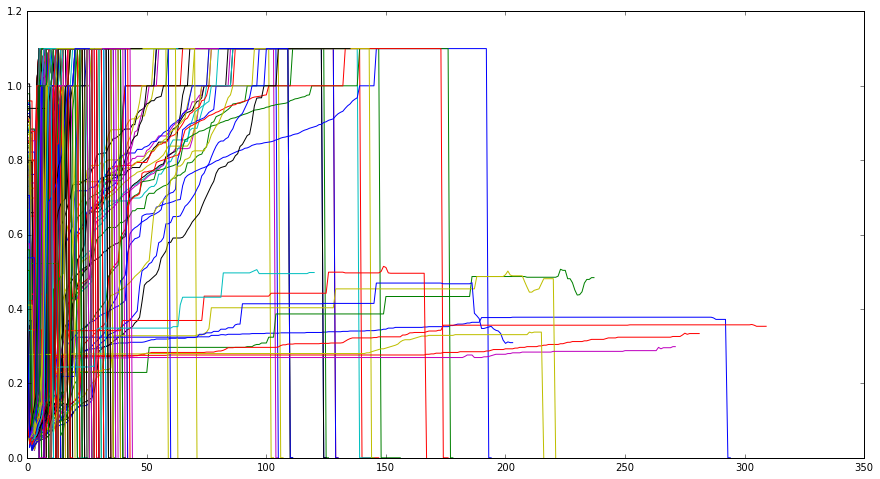

In [28]:
def get_mem_actual_use(container_name, snapshot_dataframe, snapshot_mem_profile):
  container_starttime = snapshot_dataframe.loc[container_name,'start']
  container_endtime = snapshot_dataframe.loc[container_name,'end']
  rescaled_container_starttime = container_starttime / 1000
  rescaled_container_endtime = container_endtime / 1000
  duration = rescaled_container_endtime - rescaled_container_starttime
  container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
  data = np.linspace(0,0,duration)
  container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

  mem_container_filtered = snapshot_mem_profile[(snapshot_mem_profile.name == container_name)]
  index = mem_container_filtered.timestamp.tolist()
  # get resident memory
  mem = mem_container_filtered.res.tolist()
  # get share memory
  #mem = mem_container_filtered.shr.tolist()
  # get virt memory
  #mem = mem_container_filtered.virt.tolist()
  container_data1 = pd.Series(mem,index=pd.to_datetime(index,unit='s'))
  container_data3 = container_data1 + container_data2
  container_data4 = container_data3.interpolate(method='time')
  for index in container_data4.index:
    if pd.isnull(container_data4[index]):
      container_data4[index] = container_data4.mean()
  if len(container_data4) > len(container_data2):
    a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
    if debug == True:
        print(a)
    #print(container_data4)
    #print(container_data3)
    #print(container_data2.index)
    #raise Exception('Return length mismatch')
    
  return container_data4

# Filter to remove containers with no informaction of the node, or to select specific nodes
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
for i in SnapshotDFFiltered.index:
  a = get_mem_actual_use(i,snapshot_dataframe, snapshot_mem_profile)
  a = [ x / (1024*1024*1024) for x in a ]
  plt.plot(a)

Total physical cores in these nodes: 56 cores
Total virtual cores reserved for YARN in these nodes: 72 cores
Processing application_1464174962044_0284
Processing application_1464174962044_0285
Processing application_1464174962044_0286
Processing application_1464174962044_0287
Processing application_1464174962044_0288
Processing application_1464174962044_0284
Processing application_1464174962044_0285
Processing application_1464174962044_0286
Processing application_1464174962044_0287
Processing application_1464174962044_0288
Total physical memory in these nodes: 108.033714294 GBs
Total memory reserved for YARN in these nodes: 75.0 GBs
Processing application_1464174962044_0284
Processing application_1464174962044_0285
Processing application_1464174962044_0286
Processing application_1464174962044_0287
Processing application_1464174962044_0288
Processing application_1464174962044_0284
Processing application_1464174962044_0285
Processing application_1464174962044_0286
Processing application_

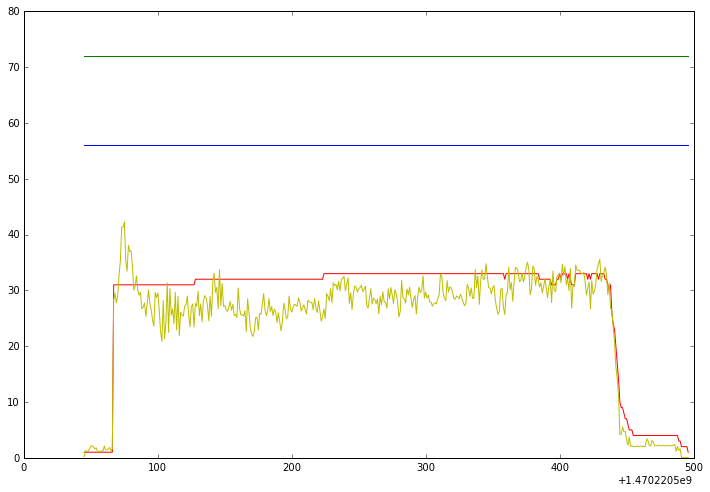

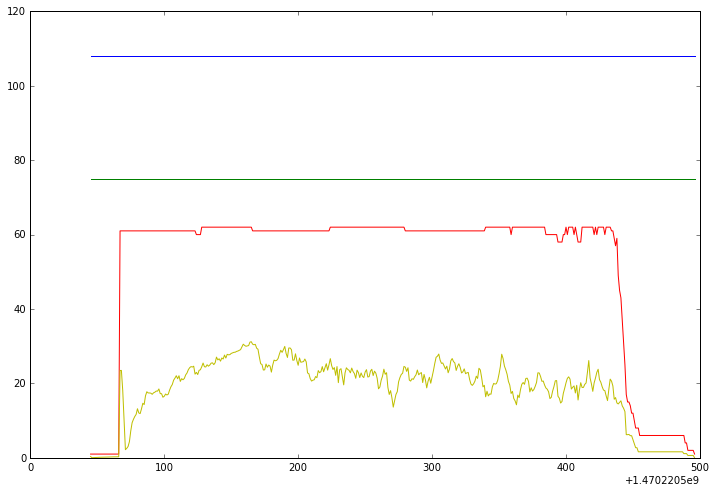

In [30]:
# Filter to remove containers with no informaction of the node, or to select specific nodes
# SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]

# Filter to select specific nodes
SnapshotDFFiltered = SnapshotDFSorted
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.node != 'svr05.spo:45454')]
#SnapshotDFFiltered = fill_null_container(SnapshotDFFiltered)
# Filter to select specific apps
# SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.app == 'application_1458297422021_0016')]
# get list of application
application_list = SnapshotDFFiltered.app.unique().tolist()
# limit number of app to draw
# application_list = application_list[:1]

'''FOR CPU'''
SnapshotDFFiltered_group_node = SnapshotDFFiltered.groupby("node")
total_phy_CPU = SnapshotDFFiltered_group_node.n_CPU.mean().sum() #assume capacity has no change
total_rsrv_CPU = SnapshotDFFiltered_group_node.CPU_rsrv.mean().sum() #assume capacity has no change
print('Total physical cores in these nodes: %s cores' % total_phy_CPU)
print('Total virtual cores reserved for YARN in these nodes: %s cores' % total_rsrv_CPU)

# create vector zero
rescaled_snapshot_starttime = snapshot_starttime / 1000
rescaled_snapshot_endtime = snapshot_endtime / 1000
rescaled_snapshot_duration = rescaled_snapshot_endtime - rescaled_snapshot_starttime
time = np.linspace(rescaled_snapshot_starttime, rescaled_snapshot_endtime-1,rescaled_snapshot_duration)
zero_vector = pd.Series(np.linspace(0, 0,rescaled_snapshot_duration), index=time)
base_vector = zero_vector

phy_CPU = np.linspace(total_phy_CPU,total_phy_CPU,rescaled_snapshot_duration)
rsrv_CPU = np.linspace(total_rsrv_CPU,total_rsrv_CPU,rescaled_snapshot_duration)
phy_CPU = pd.Series(phy_CPU,index=time)
rsrv_CPU = pd.Series(rsrv_CPU,index=time)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(phy_CPU,'-b')
ax.plot(rsrv_CPU,'-g')

# Allocated CPU
for application in application_list:
  print('Processing %s' % (application))
  for index in SnapshotDFFiltered.index:
    if SnapshotDFFiltered.loc[index,'app'] == application:
      # get CPU allocated for that container
      container_starttime = SnapshotDFFiltered.loc[index,'start']
      container_endtime = SnapshotDFFiltered.loc[index,'end']
      rescaled_container_starttime = container_starttime / 1000
      rescaled_container_endtime = container_endtime / 1000
      container_duration = rescaled_container_endtime - rescaled_container_starttime
      container_time_index = np.linspace(rescaled_container_starttime,rescaled_container_endtime-1,container_duration)
      container_value = np.linspace(SnapshotDFFiltered.loc[index,'CPU'],
                                    SnapshotDFFiltered.loc[index,'CPU'],
                                    container_duration)
      container_data = pd.Series(container_value, index=container_time_index)
      # checking if all points in container data belongs to the snapshot timeframe
      check = set(container_time_index) - set(time)
      if len(check): #not empty
        raise Exception("Error, data point's mismatch")
      # matching the container data with the length of the snapshot
      container_data = container_data + zero_vector
      container_data = container_data.fillna(0)
      # do stackplot
      # create drawing vector based on base_vector
      container_data = container_data + base_vector
      base_vector = container_data # update base_vector for next iteration
      #ax.plot(container_data,'-r')
ax.plot(base_vector,'-r')

# Actual Used CPU
base_vector = zero_vector
for application in application_list:
  print('Processing %s' % (application))
  for index in SnapshotDFFiltered.index:
    if SnapshotDFFiltered.loc[index,'app'] == application:
      # get CPU allocated for that container
      container_starttime = SnapshotDFFiltered.loc[index,'start']
      container_endtime = SnapshotDFFiltered.loc[index,'end']
      rescaled_container_starttime = container_starttime / 1000
      rescaled_container_endtime = container_endtime / 1000
      container_duration = rescaled_container_endtime - rescaled_container_starttime
      container_time_index = np.linspace(rescaled_container_starttime,rescaled_container_endtime-1,container_duration)
      '''Get actual CPU used '''
      actual_data_use = get_cpu_actual_use(index,snapshot_dataframe, snapshot_cpu_profile)
      actual_data_use = actual_data_use.tolist()
      '''because the return may have lengh longer, we generate the container_time_index again'''
      container_time_index = np.linspace(rescaled_container_starttime,
                                         rescaled_container_starttime+len(actual_data_use)-1,
                                         len(actual_data_use))
      container_data = pd.Series(actual_data_use, index=container_time_index)
      # checking if all points in container data belongs to the snapshot timeframe
      check = set(container_time_index) - set(time)
      if len(check): #not empty
        raise Exception("Error, data point's mismatch")
      # matching the container data with the length of the snapshot
      container_data = container_data + zero_vector
      container_data = container_data.fillna(0)
      # do stackplot
      # create drawing vector based on base_vector
      container_data = container_data + base_vector
      base_vector = container_data # update base_vector for next iteration
      #ax.plot(container_data,'-y')
ax.plot(base_vector,'-y')

'''FOR MEMORY'''
total_phy_mem = SnapshotDFFiltered_group_node.n_mem.mean().sum() #assume capacity has no change
total_rsrv_mem = SnapshotDFFiltered_group_node.mem_rsrv.mean().sum() #assume capacity has no change
# convert from KB to GB
total_phy_mem = float(total_phy_mem) / (1024*1024)
total_rsrv_mem = float(total_rsrv_mem) / (1024*1024)
print('Total physical memory in these nodes: %s GBs' % total_phy_mem)
print('Total memory reserved for YARN in these nodes: %s GBs' % total_rsrv_mem)

phy_mem = np.linspace(total_phy_mem,total_phy_mem,rescaled_snapshot_duration)
rsrv_mem = np.linspace(total_rsrv_mem,total_rsrv_mem,rescaled_snapshot_duration)
phy_mem = pd.Series(phy_mem,index=time)
rsrv_mem = pd.Series(rsrv_mem,index=time)

fig_mem = plt.figure(figsize=(12,8))
ax_mem = fig_mem.add_subplot(111)
ax_mem.plot(phy_mem,'-b')
ax_mem.plot(rsrv_mem,'-g')

base_vector = zero_vector # reset base vector
for application in application_list:
  print('Processing %s' % (application))
  for index in SnapshotDFFiltered.index:
    if SnapshotDFFiltered.loc[index,'app'] == application:
      # get mem allocated for that container
      container_starttime = SnapshotDFFiltered.loc[index,'start']
      container_endtime = SnapshotDFFiltered.loc[index,'end']
      rescaled_container_starttime = container_starttime / 1000
      rescaled_container_endtime = container_endtime / 1000
      container_duration = rescaled_container_endtime - rescaled_container_starttime
      container_time_index = np.linspace(rescaled_container_starttime,rescaled_container_endtime-1,container_duration)
      mem = float(SnapshotDFFiltered.loc[index,'mem']) / (1024*1024)
      container_value = np.linspace(mem,mem,container_duration)
      container_data = pd.Series(container_value, index=container_time_index)
      # checking if all points in container data belongs to the snapshot timeframe
      check = set(container_time_index) - set(time)
      if len(check): #not empty
        raise Exception("Error, data point's mismatch")
      # matching the container data with the length of the snapshot
      container_data = container_data + zero_vector
      container_data = container_data.fillna(0)
      # do stackplot
      # create drawing vector based on base_vector
      container_data = container_data + base_vector
      base_vector = container_data # update base_vector for next iteration
      #ax_mem.plot(container_data,'-r')
ax_mem.plot(base_vector,'-r')

base_vector = zero_vector # reset base vector
for application in application_list:
  print('Processing %s' % (application))
  for index in SnapshotDFFiltered.index:
    if SnapshotDFFiltered.loc[index,'app'] == application:
      # get mem allocated for that container
      container_starttime = SnapshotDFFiltered.loc[index,'start']
      container_endtime = SnapshotDFFiltered.loc[index,'end']
      rescaled_container_starttime = container_starttime / 1000
      rescaled_container_endtime = container_endtime / 1000
      container_duration = rescaled_container_endtime - rescaled_container_starttime
      '''Get actual CPU used '''
      actual_data_use = get_mem_actual_use(index,snapshot_dataframe, snapshot_mem_profile)
      actual_data_use = actual_data_use.tolist()
      actual_data_use = [x / (1024*1024*1024) for x in actual_data_use]
      '''because the return may have lengh longer, we generate the container_time_index again'''
      container_time_index = np.linspace(rescaled_container_starttime,
                                         rescaled_container_starttime+len(actual_data_use)-1,
                                         len(actual_data_use))
      container_data = pd.Series(actual_data_use, index=container_time_index)
      # checking if all points in container data belongs to the snapshot timeframe
      check = set(container_time_index) - set(time)
      if len(check): #not empty
        raise Exception("Error, data point's mismatch")
      # matching the container data with the length of the snapshot
      container_data = container_data + zero_vector
      container_data = container_data.fillna(0)
      # do stackplot
      # create drawing vector based on base_vector
      container_data = container_data + base_vector
      base_vector = container_data # update base_vector for next iteration
      #ax_mem.plot(container_data,'-y')
ax_mem.plot(base_vector,'-y')

# Calculate free memory of the cluster during snapshot

In [16]:
SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.app == 'application_1458297422021_0016')]
for index in SnapshotDFFiltered.index:
    duration = SnapshotDFFiltered.loc[index, 'end'] - SnapshotDFFiltered.loc[index, 'start']
    print('%d m %d s' % ((duration/1000/60),((float(duration)/1000)%60)))
SnapshotDFFiltered

14 m 10 s
0 m 17 s
0 m 15 s
0 m 14 s
0 m 16 s
0 m 14 s
0 m 15 s
0 m 15 s
0 m 15 s
0 m 15 s
0 m 38 s
0 m 50 s
0 m 38 s
0 m 38 s
0 m 17 s
0 m 14 s
0 m 16 s
0 m 51 s
0 m 52 s
0 m 12 s
0 m 17 s
0 m 49 s
0 m 52 s
0 m 49 s
0 m 15 s
0 m 11 s
0 m 16 s
0 m 15 s
0 m 11 s
0 m 14 s
0 m 11 s
0 m 14 s
0 m 16 s
0 m 15 s
0 m 18 s
0 m 17 s
0 m 10 s
0 m 11 s
0 m 12 s
0 m 11 s
0 m 19 s
0 m 10 s
0 m 20 s
9 m 12 s
0 m 30 s
0 m 13 s
0 m 33 s
0 m 17 s
0 m 19 s
0 m 19 s
0 m 33 s
0 m 36 s
0 m 36 s
0 m 11 s
0 m 33 s
0 m 35 s
0 m 11 s
11 m 13 s
0 m 17 s
0 m 14 s
0 m 17 s
0 m 34 s
0 m 32 s
0 m 25 s
0 m 12 s
0 m 22 s
0 m 26 s
0 m 15 s
0 m 25 s
0 m 13 s
0 m 31 s
8 m 36 s
0 m 16 s
0 m 18 s
0 m 11 s
0 m 20 s
0 m 19 s
0 m 13 s
0 m 24 s
0 m 11 s
0 m 16 s
0 m 11 s
0 m 21 s
0 m 16 s
0 m 24 s
0 m 12 s
0 m 23 s
8 m 9 s
0 m 16 s
0 m 24 s
0 m 24 s
0 m 23 s
0 m 24 s
0 m 11 s
0 m 12 s
0 m 25 s
0 m 25 s
0 m 11 s
0 m 18 s
0 m 30 s
0 m 12 s
9 m 45 s
0 m 32 s
0 m 13 s
0 m 21 s
0 m 11 s
0 m 19 s
0 m 15 s
0 m 13 s
0 m 12 s
0 m 15 s


start            end  \
container_e107_1458297422021_0016_01_000001  1459951246869  1459952097645   
container_e107_1458297422021_0016_01_000006  1459951263425  1459951281289   
container_e107_1458297422021_0016_01_000013  1459951263432  1459951279132   
container_e107_1458297422021_0016_01_000015  1459951263433  1459951277831   
container_e107_1458297422021_0016_01_000004  1459951263433  1459951280357   
container_e107_1458297422021_0016_01_000016  1459951263434  1459951278002   
container_e107_1458297422021_0016_01_000009  1459951263435  1459951278511   
container_e107_1458297422021_0016_01_000011  1459951263435  1459951278443   
container_e107_1458297422021_0016_01_000010  1459951263436  1459951278756   
container_e107_1458297422021_0016_01_000012  1459951263453  1459951278843   
container_e107_1458297422021_0016_01_000020  1459951263457  1459951301472   
container_e107_1458297422021_0016_01_000023  1459951263458  1459951314255   
container_e107_1458297422021_0016_01_000019  1459951263458  1459951302189   
container_e107_1458297422021_0016_01_000018  1459951263459  1459951301881   
container_e107_1458297422021_0016_01_000007  1459951263471  1459951280867   
container_e107_1458297422021_0016_01_000017  1459951263472  1459951277582   
container_e107_1458297422021_0016_01_000003  1459951263474  1459951280156   
container_e107_1458297422021_0016_01_000022  1459951263475  1459951314718   
container_e107_1458297422021_0016_01_000021  1459951263478  1459951316061   
container_e107_1458297422021_0016_01_000005  1459951263479  1459951275632   
container_e107_1458297422021_0016_01_000002  1459951263480  1459951280884   
container_e107_1458297422021_0016_01_000031  1459951263497  1459951312628   
container_e107_1458297422021_0016_01_000030  1459951263537  1459951316243   
container_e107_1458297422021_0016_01_000032  1459951263538  1459951313392   
container_e107_1458297422021_0016_01_000033  1459951277018  1459951292613   
container_e107_1458297422021_0016_01_000034  1459951278000  1459951289956   
container_e107_1458297422021_0016_01_000036  1459951279038  1459951295829   
container_e107_1458297422021_0016_01_000037  1459951279044  1459951294153   
container_e107_1458297422021_0016_01_000035  1459951279047  1459951290743   
container_e107_1458297422021_0016_01_000038  1459951279049  1459951293819   
container_e107_1458297422021_0016_01_000039  1459951280043  1459951291636   
container_e107_1458297422021_0016_01_000040  1459951280053  1459951294305   
container_e107_1458297422021_0016_01_000041  1459951280085  1459951296250   
container_e107_1458297422021_0016_01_000042  1459951281050  1459951296240   
container_e107_1458297422021_0016_01_000043  1459951281064  1459951299531   
container_e107_1458297422021_0016_01_000048  1459951282077  1459951299723   
container_e107_1458297422021_0016_01_000049  1459951283104  1459951293707   
container_e107_1458297422021_0016_01_000052  1459951292142  1459951303630   
container_e107_1458297422021_0016_01_000053  1459951293146  1459951305919   
container_e107_1458297422021_0016_01_000055  1459951294175  1459951305336   
container_e107_1458297422021_0016_01_000058  1459951295195  1459951314627   
container_e107_1458297422021_0016_01_000057  1459951295200  1459951306061   
container_e107_1458297422021_0016_01_000056  1459951295201  1459951315356   
container_e107_1458297422021_0016_01_000059  1459951296217  1459951848395   
container_e107_1458297422021_0016_01_000060  1459951297194  1459951328132   
container_e107_1458297422021_0016_01_000061  1459951298197  1459951311787   
container_e107_1458297422021_0016_01_000062  1459951298198  1459951332060   
container_e107_1458297422021_0016_01_000064  1459951300212  1459951317557   
container_e107_1458297422021_0016_01_000063  1459951300212  1459951320075   
container_e107_1458297422021_0016_01_000066  1459951301242  1459951321174   
container_e107_1458297422021_0016_01_000067  1459951302251  1459951335612   
container_e107_1458297422021_0016_01_000069  1459